In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Attention, Dropout, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import plot_model

2025-03-10 17:25:46.238686: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 17:25:46.249332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741623946.262960   28645 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741623946.267093   28645 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 17:25:46.280439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
np.random.seed(42)

In [3]:
train = pd.read_parquet("train.parquet", engine = "pyarrow")
test = pd.read_parquet("test.parquet", engine = "pyarrow")
X_train, y_train = train["clean_text"].values, train["HATEFUL"].values
X_test, y_test = test["clean_text"].values, test["HATEFUL"].values

In [4]:
total_palabras = [palabra for frase in train["clean_text"] for palabra in frase.split()]
len(np.unique(total_palabras))

38177

In [5]:
VOCAB_SIZE = 35000
MAX_LENGTH = 40
EMBEDDING_DIM = 128

In [6]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [7]:
train_tokens = tokenizer.texts_to_sequences(X_train)
test_tokens = tokenizer.texts_to_sequences(X_test)

In [8]:
#Texto preprocesado
train_tokens_pad = pad_sequences(train_tokens, maxlen=MAX_LENGTH, 
                                 padding='post', truncating='post')

test_tokens_pad = pad_sequences(test_tokens, maxlen=MAX_LENGTH, 
                                padding='post', truncating='post')

In [9]:
print(f"Tamaño entrenamiento: {train_tokens_pad.shape} ")
print(f"Tamaño test: {test_tokens_pad.shape} ")

Tamaño entrenamiento: (33640, 40) 
Tamaño test: (10643, 40) 


In [10]:
#Modelo BiLSTM

class BiLSTM(Model):

    def __init__(self,vocab_size, emb_dim, max_length,drop_rate = 0.25):

        super(BiLSTM, self).__init__()

        self.embedding = Embedding(input_dim = vocab_size + 1, 
                                   output_dim=emb_dim, 
                                   input_length=max_length)
        self.bilstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.25))
        self.attention = Attention()
        self.flatten = GlobalAveragePooling1D()

        self.dense1 = Dense(128, activation='relu')
        self.dropout = Dropout(drop_rate)
        self.output_layer = Dense(1, activation = "sigmoid")

    def call(self,inputs):

        x = self.embedding(inputs)
        x = self.bilstm(x)
        x = self.attention([x, x])  # Mecanismo de atención
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        return self.output_layer(x)
        

In [11]:
model = BiLSTM(vocab_size=VOCAB_SIZE, emb_dim=EMBEDDING_DIM, max_length=MAX_LENGTH)

/home/airamariza/anaconda3/envs/my_env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-03-10 17:26:02.000091: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [13]:
class_weights

{0: 0.5909633897828683, 1: 3.2483584395519505}

In [14]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
model.compile(loss = loss, optimizer= "adam", metrics = ["accuracy"])

In [15]:
history = model.fit(train_tokens_pad, 
                    y_train, 
                    epochs= 5,
                    verbose=1,
                    batch_size= 128,
                    class_weight=class_weights)

Epoch 1/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 121ms/step - accuracy: 0.6216 - loss: 0.6747
Epoch 2/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - accuracy: 0.8508 - loss: 0.4182
Epoch 3/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - accuracy: 0.9053 - loss: 0.2614
Epoch 4/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step - accuracy: 0.9316 - loss: 0.1795
Epoch 5/5
263/263 ━━━━━━━━━━━━━━━━━━━━ 37s 142ms/step - accuracy: 0.9500 - loss: 0.1342


In [23]:
y_prob = model.predict(test_tokens_pad)
y_pred = list(map(lambda x : 1 if x >= 0.5 else 0, y_prob))

333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [19]:
y_prob_train = model.predict(train_tokens_pad)
y_pred_train = list(map(lambda x : 1 if x >= 0.5 else 0, y_prob_train))

1052/1052 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step


In [21]:
fpr_t, tpr_t, thresholds_t = roc_curve(y_train, y_prob_train)
roc_auc = auc(fpr_t, tpr_t)
roc_auc

0.9955300459702336

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      8961
           1       0.42      0.62      0.50      1682

    accuracy                           0.81     10643
   macro avg       0.67      0.73      0.69     10643
weighted avg       0.84      0.81      0.82     10643



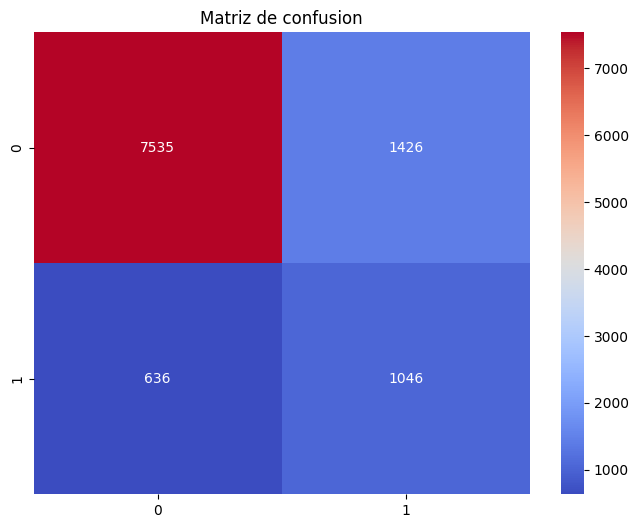

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.title("Matriz de confusion")
sns.heatmap(cm, annot=True, fmt = "d", cmap="coolwarm")
plt.show()

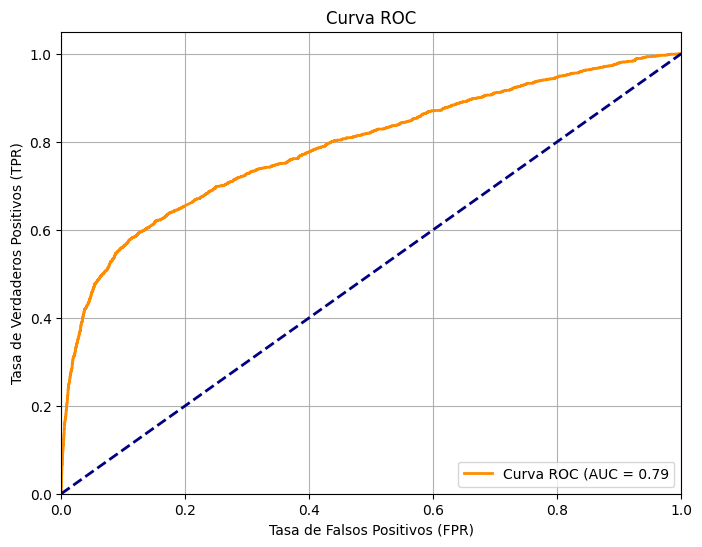

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
